**Dependencies**

In [0]:
!sudo apt-get update && sudo apt-get install cmake libopenmpi-dev python3-dev zlib1g-dev
!pip install stable-baselines
!pip install pybullet

In [0]:
import os
import gym
import pybullet_envs

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import SubprocVecEnv,DummyVecEnv
from stable_baselines.bench import Monitor
from stable_baselines import PPO2
from stable_baselines.results_plotter import load_results, ts2xy

import pybullet_envs

**Mount drive for saving model/logging/video files**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

**Configuration**

In [0]:
env_id = 'AntBulletEnv-v0'
#env_id = 'HumanoidBulletEnv-v0'
#env_id = 'HalfCheetahBulletEnv-v0'

model_dir = '/content/gdrive/My Drive/models/' + env_id + '/'
model_name = env_id + '_model'

log_dir = model_dir + 'logs/'
vid_dir = '/content/gdrive/My Drive/videos/'
model_number = '1109'

#learning
timesteps = int(1e8)
# Number of processes to use
num_cpu = 128

**Callback function which saves the model**

In [0]:
n_steps = 0

def callback(_locals, _globals):
    global n_steps
    # Save model every 20 calls
    if (n_steps + 1) % 20 == 0:
        model.save(model_dir + model_name + str(n_steps))
    n_steps += 1

    return True

**Creating gym environment**

In [0]:
def make_env(rank, seed=0):

    def _init():
        env = gym.make(env_id)
        env.seed(seed + rank)
        env = Monitor(env, os.path.join(log_dir, str(rank)), allow_early_resets=True)
        return env

    return _init

In [0]:
# Create the vectorized environment
env = SubprocVecEnv([make_env(i) for i in range(num_cpu)])

#create new model
model = PPO2(MlpPolicy, env, verbose=1)

#load existing model
#model = PPO2.load(model_dir + model_name + '_final', env)

**Start Learning**

In [0]:
# Train the agent
model.learn(total_timesteps=timesteps, callback=callback)

model.save(model_dir + model_name + '_final')


**Plotting the learning process**

In [0]:
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title=env_id):
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " (Smoothed)")
    plt.show()

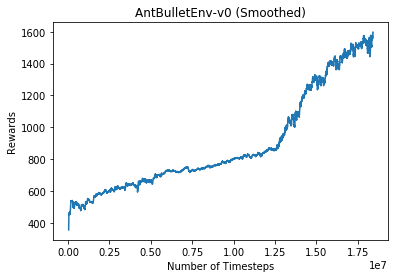

In [20]:
plot_results(log_dir)

**Creating a video from a saved model**

In [0]:
env = gym.make(env_id)
env = gym.wrappers.Monitor(env, vid_dir)
env = DummyVecEnv([lambda: env])

#load model
model = PPO2.load(model_dir + model_name + model_number, env)

In [0]:
obs = env.reset()
for i in range(10000):
  actions, _states = model.predict(obs)
  obs, rewards, dones, info = env.step(actions)